In [73]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import Callable, Tuple
import random
import math
from basic_units import radians


In [107]:
def get_rad_ticks(range_start: int = 0, range_stop: int = 2, step: int = 1) -> Tuple:
    # """Generate ticks and labels for them in given interval

    #   Parameters
    #   ----------
    #   range_start: int
    #     Left edge of the interval. Will be included in the range.
    #   range_stop: int
    #     Right edge of the interval. Won't be included in the range.
    #   step: int
    #      An integer number specifying the incrementation.

    #   Returns
    #   -------
    #   Tuple
    #     Tuple with two arrays: ticks and labels
    # """
    labels = []

    for i in range(range_start, range_stop, step):
        if i == 0:
            labels.append(str(i))
            continue
        if i == 1:
            labels.append('π')
            continue
        if i == -1:
            labels.append('-π')
            continue
        labels.append(str(i) + 'π')
    
    ticks = [i*math.pi for i in range(range_start, range_stop, step)]
    return ticks, labels

In [74]:
def noise(freq, series_len):
  # """Return single frequency noise

  #   Parameters
  #   ----------
  #   freq: int
  #     Noise frequency
  #   series_len: int
  #     Length of noise vector
  #
  #   Returns
  #   -------
  #   [float]
  #     The noise vector of a given frequency
  # """
  phase = random.uniform(0, 2*math.pi)
  return np.array([math.sin(2*math.pi * freq*x/series_len + phase) for x in range(series_len)])

In [75]:
def generate_noise(series_len = 1_000, amplitude = lambda f: 1, frequencies = range(1, 1001), random_seed = 0, debugging = False):
  # """Generates noise of different spectrum

  #   Parameters
  #   ----------
  #   series_len: int
  #     Length of noise vector
  #   amplitude: Callable[[int], float]
  #     Should return amplitude depending on frequency. Return const 1 by default.
  #   frequencies: [int]
  #     Range of frequencies
  #   random_seed: int
  #     Value for random.seed()
  #   debugging: boolean
  #     Flag to activate debug mode
  #
  #   Returns
  #   -------
  #   [float]
  #     The noise vector of a given spectrum
  # """
  random.seed(random_seed)
  sum_of_noises = [0.0] * series_len
  amplitudes = np.array([amplitude(f) for f in frequencies])
  noises = np.array([noise(f, series_len) for f in frequencies])

  if debugging:
    print('amplitudes length = {}'.format(len(amplitudes)))
    print('noises length = {}'.format(len(noises)))

  for k in range(len(noises)):
    sum_of_noises += amplitudes[k] * noises[k]

  return sum_of_noises

In [76]:
def derivative_next_value(x_t: float, f_t: float = 0) -> float:
  # """Calculate value of x'(t+1) depending on x(t) and f(t)

  #   Parameters
  #   ----------
  #   x_t: float
  #     Value of the function in point t
  #   f_t: float
  #     Noise in point t

  #   Returns
  #   -------
  #   float
  #     Value of the derivative in point t+1
  # """
  return np.sin(x_t) + f_t


In [77]:
def function_next_value(x_t: float, delta: float = 0.1, f_t: float = 0) -> float:
  # """Calculate value of x(t+1) depending on x(t), f(t) and delta t

  #   Parameters
  #   ----------
  #   x_t: float
  #     Value of the function in point t
  #   delta: float
  #     Increment of the argument
  #   f_t: float
  #     Noise in point t

  #   Returns
  #   -------
  #   float
  #     Value of the function in point t+1
  # """
  d_t = derivative_next_value(x_t, f_t)
  return x_t + delta*d_t

## Common settings

In [152]:
series_len = 1050

random.seed(0)

# Without noise

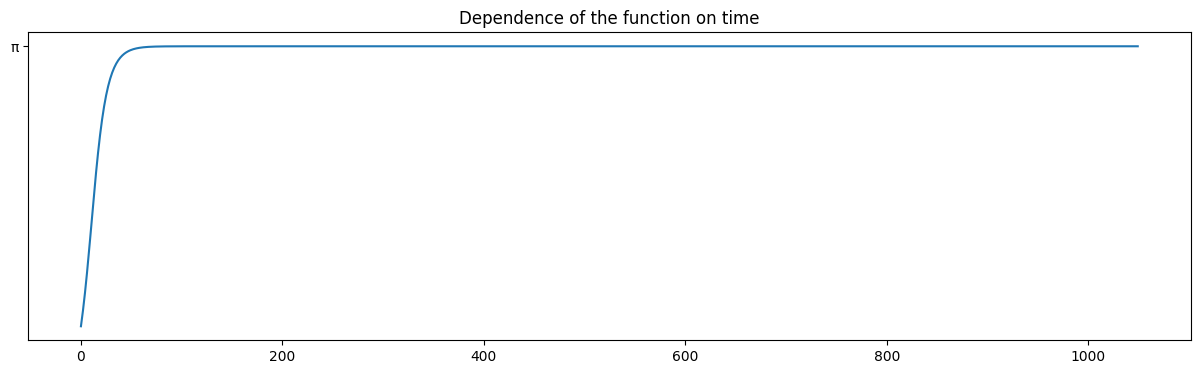

In [156]:
x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t)

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(0, 2))
plt.title('Dependence of the function on time')
plt.plot(x_ts)

# White noise

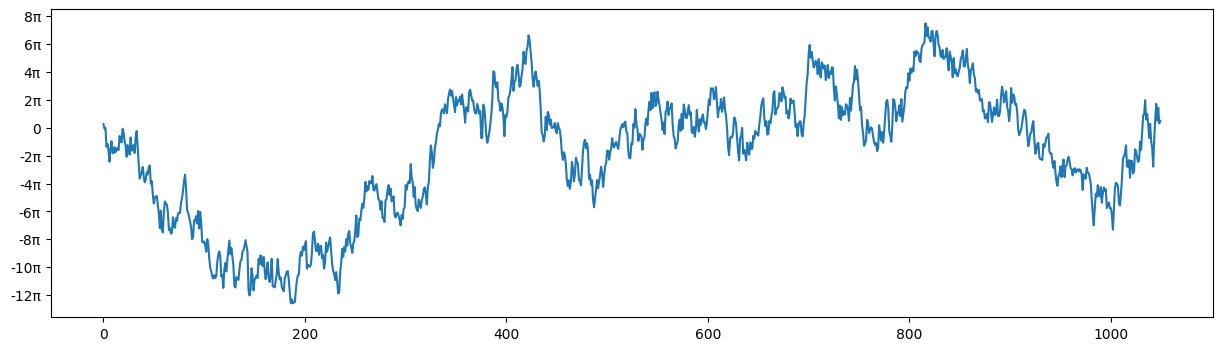

In [157]:
white_noise = generate_noise(series_len)

x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t, f_t=white_noise[t])

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(-14, 9, 2))
plt.plot(x_ts)

## Brown noise

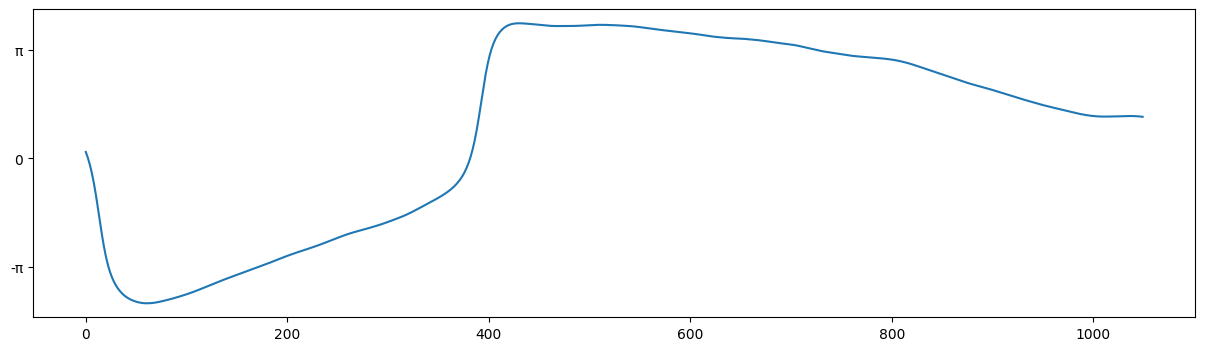

In [158]:
brown_noise = generate_noise(series_len, amplitude=lambda f: 1/f/f)

x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t, f_t=brown_noise[t])

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(-1, 2))
plt.plot(x_ts)

## Pink noise

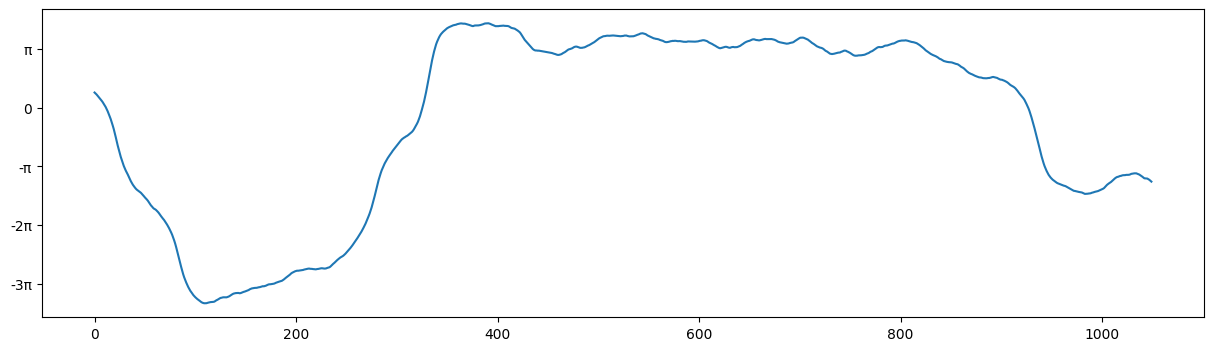

In [159]:
pink_noise = generate_noise(series_len, amplitude=lambda f: 1/f)

x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t, f_t=pink_noise[t])

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(-3, 2))
plt.plot(x_ts)

## Blue noise

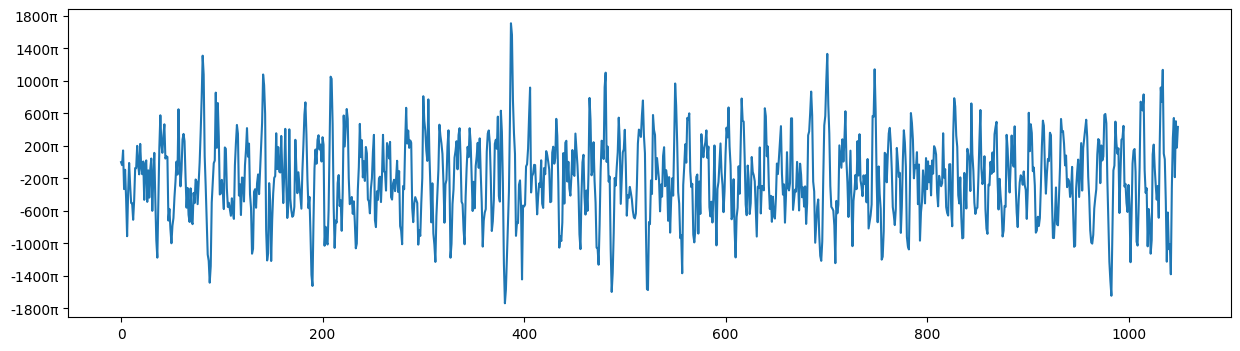

In [160]:
blue_noise = generate_noise(series_len, amplitude=lambda f: f)

x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t, f_t=blue_noise[t])

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(-1800, 2000, 400))
plt.plot(x_ts)

## Violet noise

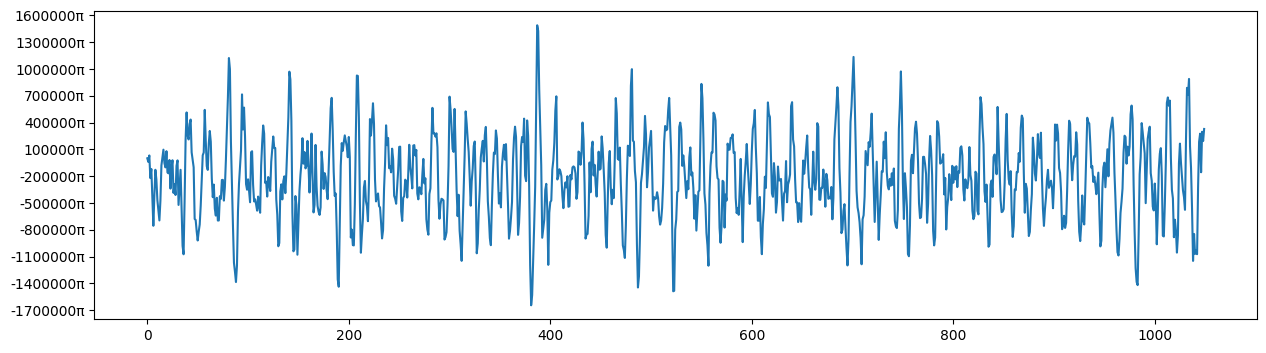

In [161]:
violet_noise = generate_noise(series_len, amplitude=lambda f: f*f)

x_t = np.random.rand()
x_ts = []
for t in range(series_len):
  x_ts.append(x_t)
  x_t = function_next_value(x_t, f_t=violet_noise[t])

plt.figure(figsize=(15, 4))
plt.yticks(*get_rad_ticks(-1_700_000, 1_700_000, 300_000))
plt.plot(x_ts)